<a href="https://colab.research.google.com/github/coraldx5/generativeai_intro_book/blob/master/chap08_mnist_digit_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第8章：VAEを作ってみよう
- 手書きの数字を入出力するVAEを作成します

## GPUが使用可能であることを確認（第7章と同じ）
- 手動で設定する場合には「ランタイム」メニュー→「ランタイムのタイプを変更」→「ハードウェア アクセラレータ」をGPU（T4 GPU、など）に設定→「保存」ボタンを押下

In [1]:
!nvidia-smi  # ←GPUが使用可能であることを確認

Tue Jul 30 14:49:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ライブラリのインポート（第7章と同じ）

In [2]:
import tensorflow as tf

# Kerasのインポート
import keras
from keras import layers
from keras import initializers

# ネットワーク（モデル）を構築するための「部品」をインポートします
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense

# モデルの構造を可視化するためのライブラリをインポートします
from tensorflow.keras.utils import plot_model

# グラフや画像を描画するためのライブラリをインポートします
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
# 結果の再現性を担保するために乱数シードを固定
keras.utils.set_random_seed(821)
tf.config.experimental.enable_op_determinism()

## 学習に使うデータの準備（第7章と同じ）

11490434/11490434 [==============================] - 2s 0us/step
学習用画像の形状:  (60000, 28, 28)
学習用ラベルの形状:  (60000,)
検証用画像の形状:  (10000, 28, 28)
検証用ラベルの形状:  (10000,)


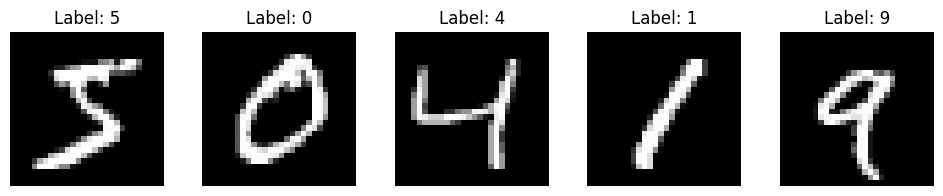

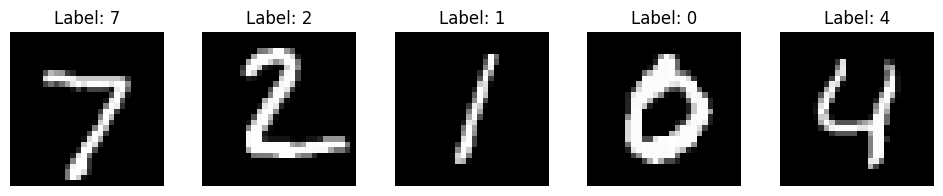

In [3]:
# @title ## データの準備（第7章と同じ）
# MNISTデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# データの正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

# データの確認
print("学習用画像の形状: ", x_train.shape)
print("学習用ラベルの形状: ", y_train.shape)
print("検証用画像の形状: ", x_test.shape)
print("検証用ラベルの形状: ", y_test.shape)

# データの可視化
def plot_sample_images(images, labels, num_samples):
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 学習用データから5個のサンプルを表示
plot_sample_images(x_train, y_train, num_samples=5)
# 検証用データから5個のサンプルを表示
plot_sample_images(x_test, y_test, num_samples=5)

In [4]:
# @title ## 学習用/検証用データに含まれる各ラベルの枚数を確認（第7章と同じ）
# 各ラベルの数を計算する関数
def count_labels(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

# 学習用データと検証用データのラベル数を計算
train_label_counts = count_labels(y_train)
test_label_counts = count_labels(y_test)

# データフレームにまとめる
df = pd.DataFrame({
    'ラベル': list(train_label_counts.keys()),
    '学習用データの数': list(train_label_counts.values()),
    '検証用データの数': [test_label_counts.get(label, 0) for label in train_label_counts.keys()]
})

# データフレームを表示
df

,ラベル,学習用データの数,検証用データの数
0,0,5923,980
1,1,6742,1135
2,2,5958,1032
3,3,6131,1010
4,4,5842,982
5,5,5421,892
6,6,5918,958
7,7,6265,1028
8,8,5851,974
9,9,5949,1009


## VAEを動かしてみよう

In [12]:
# @title ## 学習済みモデルを読み込んで構造を確認しよう
# @markdown - 2次元の潜在空間を持つVAE（`vae`）を読み込みます
# @markdown - エンコーダ部（`encoder_model`）を読み込みます
# @markdown - デコーダ部（`decoder_model`）を読み込みます

from keras.layers import Lambda, Input
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.models import load_model

# 指定されたURLから学習済みモデルをダウンロードして保存
!wget -O chap08_vae_mnist.h5 https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_vae_mnist.h5
!wget -O chap08_vae_encoder_mnist.h5 https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_vae_encoder_mnist.h5
!wget -O chap08_vae_decoder_mnist.h5 https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_vae_decoder_mnist.h5

# ダウンロードしたファイルを読み込み、autoencoder01に代入
vae = load_model('chap08_vae_mnist.h5')
encoder_model = load_model('chap08_vae_encoder_mnist.h5')
decoder_model = load_model('chap08_vae_decoder_mnist.h5')

# モデルの構造を表示
vae.summary()

Model: "variational_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 encoder_model (Functional)  [(None, 2),                  100996    ['input_1[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder_model (Functional)  (None, 784)                  101520    ['encoder_model[0][2]']       
                                                                            

313/313 [==============================] - 1s 2ms/step


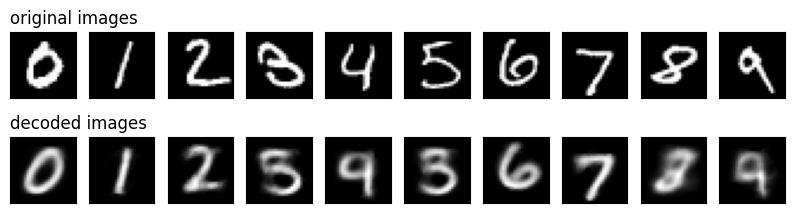

In [14]:
# テスト画像を変換
decoded_imgs = vae.predict(x_test)

# ０～９までの数字のインデックスを定義
digit_index_list = [3,2,1,18,4,15,11,0,61,7]
# 各行のラベルを設定
labels = ["original images", "decoded images"]
plt.figure(figsize=(10, 2.5))
# 各行にラベルを付ける
for row, label in enumerate(labels):
    ax = plt.subplot(2, len(digit_index_list), row * len(digit_index_list) + 1)
    ax.set_title(label, loc='left')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i, digit_index in enumerate(digit_index_list):
    # テスト画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1+len(digit_index_list))
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 0s 1ms/step


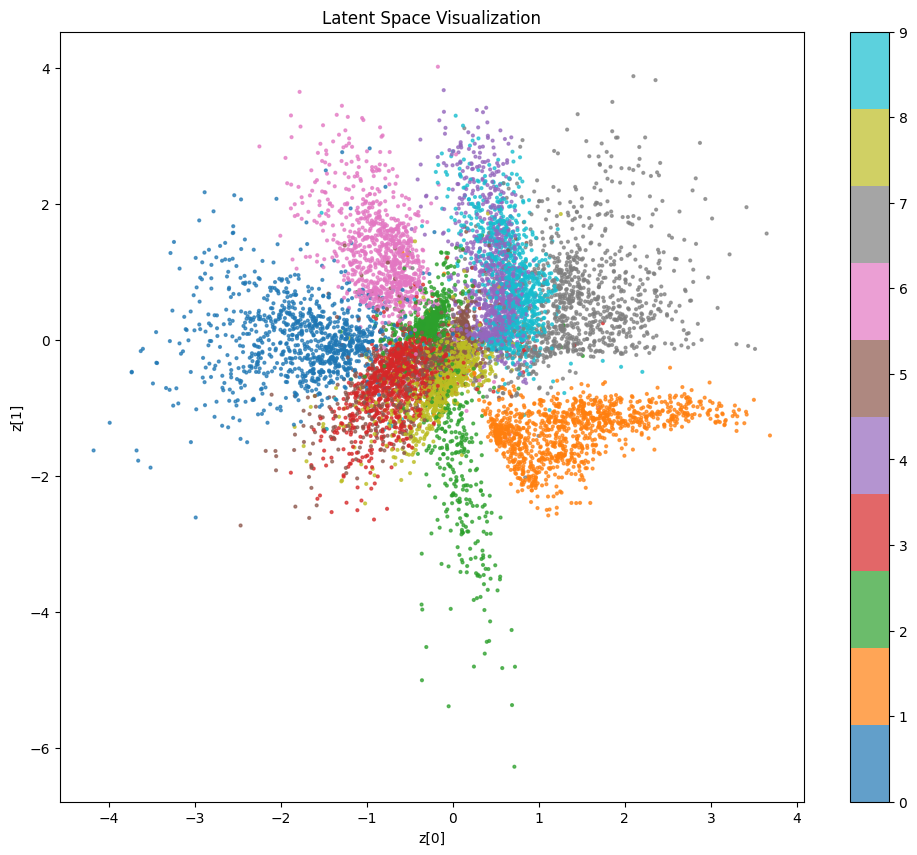

In [18]:
import matplotlib.cm as cm
def plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mnist"):
    z_mean = encoder.predict(x_test)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, s=4, alpha=0.7,cmap='tab10')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title('Latent Space Visualization')
    plt.show()

plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mlp")


79/79 [==============================] - 0s 4ms/step


<ipython-input-19-bcdd17845abc>:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(m)


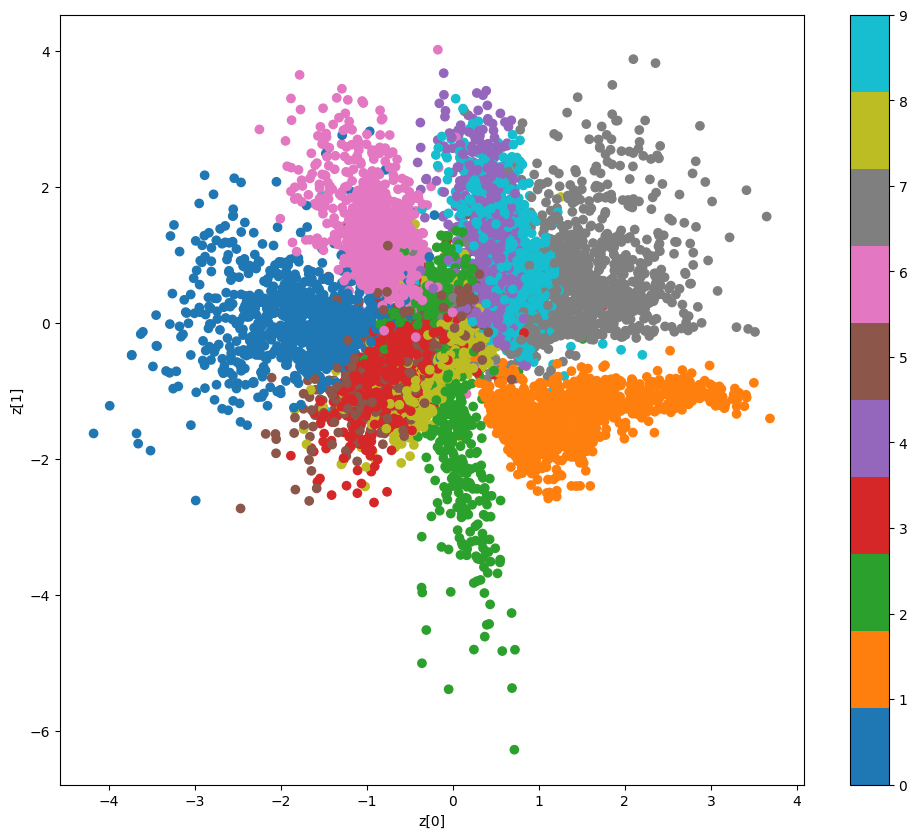

1/1 [==============================] - 0s 32ms/step


In [19]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mnist"):
    # エンコーダから潜在変数の平均を取得
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

    # 潜在空間にプロット
    plt.figure(figsize=(12, 10))
    cmap = cm.tab10
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=cmap)
    m = cm.ScalarMappable(cmap=cmap)
    m.set_array(y_test)
    plt.colorbar(m)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # (-4, -4) から (4, 4) までを分割してプロットする
    n = 10  # グリッドのサイズ
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # 生成した画像のプロット
    plt.figure(figsize=(100, 100))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# plot_results関数の呼び出し
plot_results(encoder_model,
             decoder_model,
             x_test,
             y_test,
             batch_size=128,
             model_name="vae_mlp")

In [10]:
vae.save('chap08_vae_mnist.h5')
encoder_model.save('chap08_vae_encoder_mnist.h5')
decoder_model.save('chap08_vae_decoder_mnist.h5')

vae.save('chap08_vae_mnist.keras')
encoder_model.save('chap08_vae_encoder_mnist.keras')
decoder_model.save('chap08_vae_decoder_mnist.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# @title - 画像を保存してZIP化
# Directory to save the images
import os
output_dir_test = './my_autoencoder'
output_dir_decoded = './my_autoencoder'
os.makedirs(output_dir_test, exist_ok=True)
os.makedirs(output_dir_decoded, exist_ok=True)

# Loop through the digit index list and save each image separately
for i, digit_index in enumerate(digit_index_list):
    # Save test image
    plt.figure(figsize=(10, 10))
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    plt.savefig(os.path.join(output_dir_test, f'test_image_{i}.png'))
    plt.close()

    # Save decoded image
    plt.figure(figsize=(10, 10))
    plt.imshow(decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    plt.savefig(os.path.join(output_dir_decoded, f'decoded_image_{i}.png'))
    plt.close()

# List the saved files for confirmation
saved_files_test = os.listdir(output_dir_test)
saved_files_decoded = os.listdir(output_dir_decoded)
saved_files_test, saved_files_decoded
!zip -r ./my_autoencoder.zip ./my_autoencoder

# 参考：自分でVAEを定義して学習する

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 encoder (Sequential)        (None, 4)                    100996    ['input_1[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 2)                    0         ['encoder[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                      

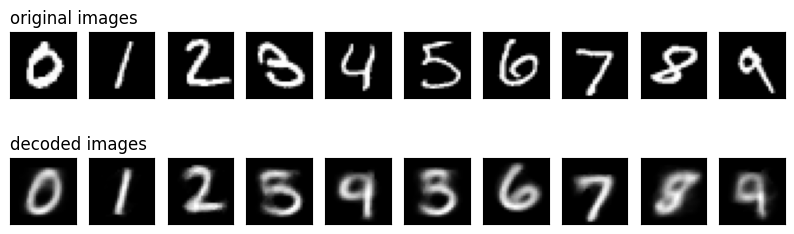

In [5]:
# @title ## VAEの定義と学習
# @markdown - このコードセルを実行すると、VAEを構築して10エポックだけ学習します（時間がかかります）

from keras.layers import Lambda, Input
from keras.models import Model
from keras.losses import mse
from keras import backend as K

# 画像のサイズを指定
image_size = 28
# 画像を1次元に変換
original_dim = 28*28
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
# ピクセル値を0-1に正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# 入力データの形状
input_shape = (original_dim,)
# 潜在変数の次元数
latent_dim = 2

# Reparametrization Trick
def sampling(args):
    z_mean, z_logvar = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), seed = 5) # ε
    return z_mean + K.exp(0.5 * z_logvar) * epsilon

# VAEモデル構築
inputs = Input(shape=input_shape)

encoder = Sequential([
    Dense(128, activation='relu', input_shape=input_shape),
    Dense(latent_dim + latent_dim)
], name='encoder')

z_mean = encoder(inputs)[:, :latent_dim]
z_logvar = encoder(inputs)[:, latent_dim:]
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logvar])

encoder_model = Model(inputs, [z_mean, z_logvar, z], name='encoder_model')
encoder_model.summary()

decoder = Sequential([
    Dense(128, activation='relu', input_shape=(latent_dim,)),
    Dense(original_dim, activation='sigmoid')
], name='decoder')

latent_inputs = Input(shape=(latent_dim,))
outputs = decoder(latent_inputs)

decoder_model = Model(latent_inputs, outputs, name='decoder_model')
decoder_model.summary()

z_output = encoder_model(inputs)[2]
outputs = decoder_model(z_output)
vae = Model(inputs, outputs, name='variational_autoencoder')

# 損失関数
# Kullback-Leibler Loss
kl_loss = 1 + z_logvar - K.square(z_mean) - K.exp(z_logvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train,
        epochs=10,
        validation_data=(x_test, None))